# Checking if a pair of stocks is cointegrated

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import quiz_tests

In [2]:
# Set plotting options
%matplotlib inline
plt.rc('figure', figsize=(16, 9))

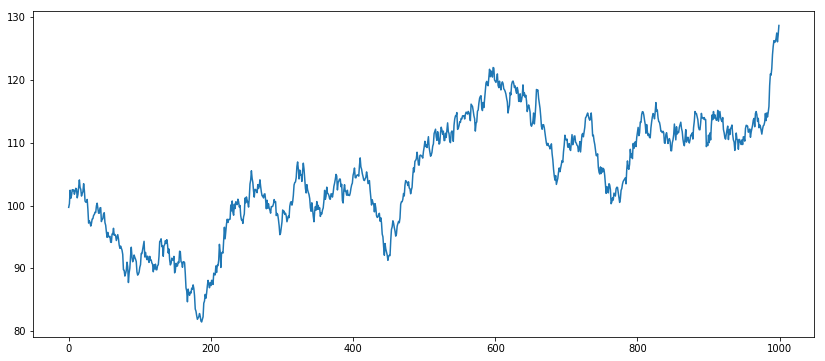

In [3]:
# just set the seed for the random number generator
np.random.seed(2018)
# use returns to create a price series
drift = 100
r1 = np.random.normal(0, 1, 1000) 
s1 = pd.Series(np.cumsum(r1), name='s1') + drift
s1.plot(figsize=(14,6))
plt.show()

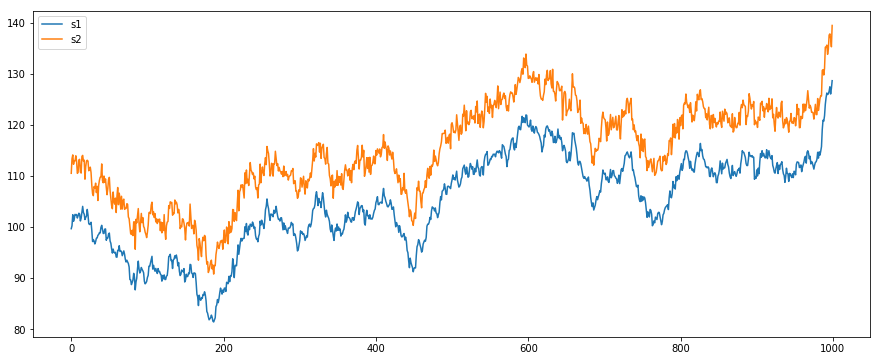

In [4]:
offset = 10
noise = np.random.normal(0, 1, 1000)
s2 = s1 + offset + noise
s2.name = 's2'
pd.concat([s1, s2], axis=1).plot(figsize=(15,6))
plt.show()

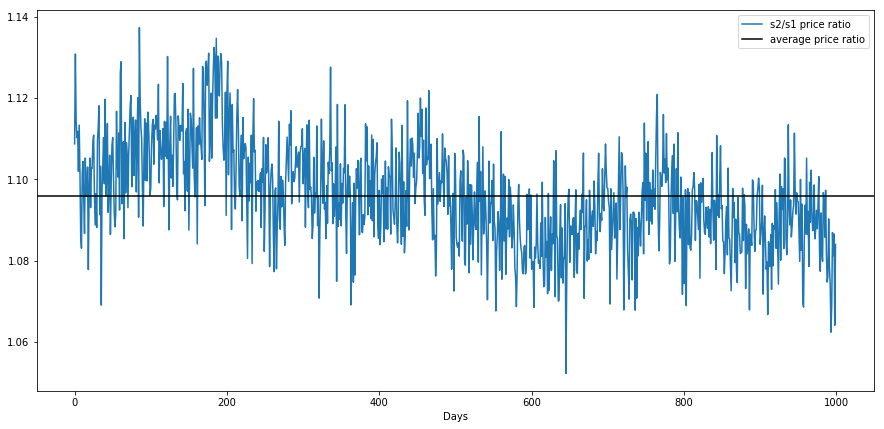

average price ratio 1.0960


In [5]:
price_ratio = s2/s1
price_ratio.plot(figsize=(15,7)) 
plt.axhline(price_ratio.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['s2/s1 price ratio', 'average price ratio'])
plt.show()
print(f"average price ratio {price_ratio.mean():.4f}")

## Calculate hedge ratio with regression

## Linear Regression

Note that the LinearRegression().fit() expects 2D numpy arrays.  Since s1 and s2 are pandas series, we can use Series.values to get the values as a numpy array. Since these are 1D arrays, we can use numpy.reshape(-1,1) to make these 1000 row by 1 column 2 dimensional arrays

In [6]:
type(s1)

pandas.core.series.Series

In [7]:
type(s1.values)

numpy.ndarray

In [8]:
s1.values.reshape(-1,1).shape

(1000, 1)

In [9]:
lr = LinearRegression()
lr.fit(s1.values.reshape(-1,1),s2.values.reshape(-1,1))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
hedge_ratio = lr.coef_[0][0]
hedge_ratio

1.0022343577912765

In [11]:
intercept = lr.intercept_[0]
intercept

9.753022747192858

In [12]:
print(f"hedge ratio from regression is {hedge_ratio:.4f}, intercept is {intercept:.4f}")

hedge ratio from regression is 1.0022, intercept is 9.7530


 ## Question
 Do you think we'll need the intercept when calculating the spread?  Why or why not?

## Calculate the spread

In [15]:
spread = s2 - s1 * hedge_ratio

In [16]:
print(f"Average spread is {spread.mean()}")

Average spread is 9.753022747192862


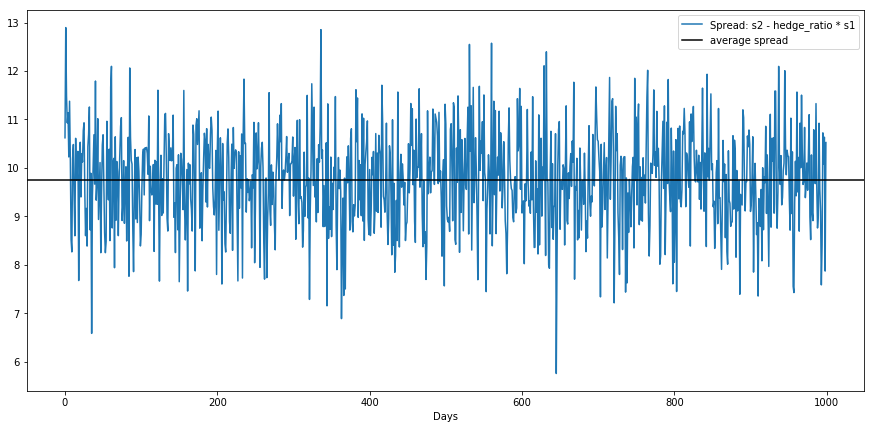

In [17]:
spread.plot(figsize=(15,7)) 
plt.axhline(spread.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['Spread: s2 - hedge_ratio * s1', 'average spread'])
plt.show()

## Let's see what we get if we include the intercept of the regression

In [18]:
spread_with_intercept = s2 - (s1 * hedge_ratio + intercept)
print(f"Average spread with intercept included is {spread_with_intercept.mean()}")

Average spread with intercept included is 2.5011104298755525e-15


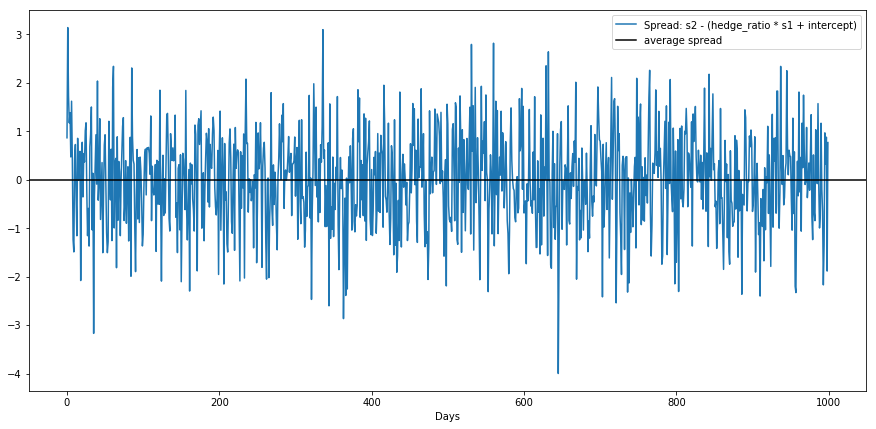

In [19]:
spread_with_intercept.plot(figsize=(15,7)) 
plt.axhline(spread_with_intercept.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['Spread: s2 - (hedge_ratio * s1 + intercept)', 'average spread'])
plt.show()

## Quiz
### Check if spread is stationary using Augmented Dickey Fuller Test

The [adfuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) function is part of the statsmodel library.

```
adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[source]

adf (float) – Test statistic
pvalue (float) – p-value
...
```

In [24]:
def is_spread_stationary(spread, p_level=0.05):
    """
    spread: obtained from linear combination of two series with a hedge ratio
    
    p_level: level of significance required to reject null hypothesis of non-stationarity
    
    returns:
        True if spread can be considered stationary
        False otherwise
    """
    # use the adfuller function to check the spread
    adf_result = adfuller(spread)
    
    # get the p-value
    pvalue = adf_result[1]
    
    print(f"pvalue {pvalue:.4f}")
    if pvalue <= p_level:
        print(f"pvalue is <= {p_level}, assume spread is stationary")
        return True
    else:
        print(f"pvalue is > {p_level}, assume spread is not stationary")
        return False
    
quiz_tests.test_is_spread_stationary(is_spread_stationary)

pvalue 0.0000
pvalue is <= 0.05, assume spread is stationary
Tests Passed


In [25]:
# Try out your function
print(f"Are the two series candidates for pairs trading? {is_spread_stationary(spread)}")

pvalue 0.0000
pvalue is <= 0.05, assume spread is stationary
Are the two series candidates for pairs trading? True


If you're stuck, you can also check out the solution [here](pairs_candidates_solution.ipynb)